# Transient simulation of organic light emitting electrochemical cell

This is sample simulation of electrochemical doping in light-emitting electrochemical cell, visualizing the effect of assumed electronic mobility model.

In [1]:
%matplotlib inline
from matplotlib import colors
import matplotlib.pylab as plt

from oedes.fvm import mesh1d
from oedes import context,init_notebook,testing
from oedes.models import lec
import numpy as np
from oedes.functions import Aux2

init_notebook()

## Model and parameters



In [2]:
def mu_func(T, E, c):
    mu0 = 5e-11
    mu1 = 5e-9
    W = 0.04
    f0 = 0.3
    f = c / 0.3e27
    return (mu1 - mu0) * Aux2((f0 - f) / W) + mu0

In [3]:
mesh = mesh1d(2e-6)
model = lec.LEC(mesh)
xinit = lec.initial_salt(model, 0.1e27)

In [4]:
def solve(mu_ions, mu_charges, voltage=5.):
    params = {'T': 300.,
              'electron.mu': mu_charges,
              'electron.level': 0.,
              'electron.N0': 0.3e27,
              'hole.mu': mu_charges,  # 5e-11,
              'hole.level': 2.,
              'hole.N0': 0.3e27,
              'electrode0.workfunction': 2.,
              'electrode1.workfunction': 0.,
              'electrode0.voltage': voltage,
              'electrode1.voltage': 0,
              'cation.mu': mu_ions,
              'anion.mu': mu_ions,
              'npi': 0,
              'epsilon_r': 3.
              }
    c = context(model,x=xinit)
    c.transient(params, 1, 1e-9)
    return c

In [5]:
def transientplot(data):
    N0 = 5e27
    n = 20
    for it, t in enumerate(10**np.linspace(-5, -1, n + 1)):
        out = data.attime(t).output()
        c = 1 - (1. - it / n)
        ncolor = colors.rgb2hex((1,1 - c,1 - c))
        pcolor = colors.rgb2hex((1 - c,1 - c,1))
        plt.plot(mesh.cells['center'] * 1e9,out['electron.c'] / N0,ncolor)
        plt.plot(mesh.cells['center'] * 1e9,out['hole.c'] / N0,pcolor)
        testing.store(out['electron.c'], rtol=1e-7, atol=1e-3 * N0)
        testing.store(out['hole.c'], rtol=1e-7, atol=1e-3 * N0)
    plt.yscale('log')
    plt.ylim([1e-5, 1.])
    plt.xlabel('$x$ [nm]')
    plt.ylabel('$c/N_0$')

## Results

In the plots below, electrons are shown in red, and holes are shown in blue.

### Concentration independent mobility

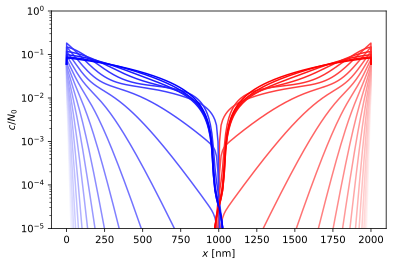

In [6]:
transientplot(solve(5e-11, 5e-11))

### Concentration dependent mobility

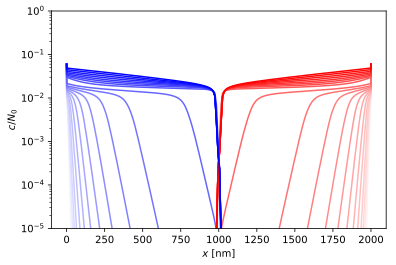

In [7]:
transientplot(solve(5e-11, mu_func))

## Reference

S.van Reenen, R.A.J.Janssen, M.Kemerink [Doping dynamics in light-emitting electrochemical cells](https://doi.org/10.1016/j.orgel.2011.07.005), Organic Electronics 12 (2011) 1746–1753.


---
This file is a part of __oedes__, an open source organic electronic device 
simulator. For more information, see <https://www.github.com/mzszym/oedes>.
